In [ ]:
%env "WANDB_NOTEBOOK_NAME" "07_homo_sine_loss_strat.ipynb"
%env WANDB_SILENT=True
%load_ext autoreload
%reload_ext autoreload
%env XLA_PYTHON_CLIENT_MEM_FRACTION=0.3

env: "WANDB_NOTEBOOK_NAME"="07_homo_sine_loss_strat.ipynb"
env: WANDB_SILENT=True
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: XLA_PYTHON_CLIENT_MEM_FRACTION=0.3


In [ ]:
import jax
import numpy as np
import jax.numpy as jnp
import equinox as eqx
import optax

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.style as mplstyle
import seaborn as sns

from NeuralNetworkEvolution.config import MLPConfig
from NeuralNetworkEvolution.activations import sin
from NeuralNetworkEvolution.mlp import CustomMLP, mlp_plot

import os
import sys
import logging
from tqdm.notebook import trange
import wandb

In [ ]:
plt.style.use('default')
sns.set_theme(context='paper', style='white', palette='viridis', font='serif',
            font_scale=2, color_codes=True, rc={'text.usetex' : True})
mplstyle.use('fast')

In [ ]:
input_size = 1
hidden_sizes = [5, 5] 
output_size = 1
initial_activation_list = [jax.nn.relu]
activation_list = [jax.nn.relu]
num_epochs = 1000
add_node_every = 50
seed = 42
key = jax.random.PRNGKey(42)
threshold = 1e-4
n_samples = 2000
learning_rate = 0.01

config = MLPConfig(input_size=input_size,
                output_size=output_size,
                hidden_sizes=hidden_sizes,
                initial_activation_list=initial_activation_list,
                seed=seed)

In [ ]:
config.__dict__.update({'n_samples': n_samples,
                        'learning_rate': learning_rate,
                        'num_epochs': num_epochs,
                        'add_node_every': add_node_every,
                        'threshold': threshold,
                        'activation_list': activation_list})

In [ ]:
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')
Description = f"Homo_sine_loss_strat__no_bias_{hidden_sizes[0]}_{hidden_sizes[1]}_{num_epochs}_{add_node_every}_{threshold}_{seed}"
fig_folder = f"../../figures/{Description}"
out_folder = f"../../output/{Description}"
os.makedirs(fig_folder, exist_ok=True)
os.makedirs(out_folder, exist_ok=True)

In [ ]:
print(f"# devices: {jax.local_device_count()}")

logging.basicConfig(level=logging.INFO, filename=f"{out_folder}/info.log", filemode="w")
console = logging.StreamHandler(sys.stdout)
console.setLevel(logging.INFO)
logging.getLogger("").addHandler(console)
logging.info(f"Description: {Description}")
logging.info(f"jax backend: {jax.lib.xla_bridge.get_backend().platform}")
logging.info(f"jax devices: {jax.devices()}")

# devices: 4
Description: Homo_sine_loss_strat__no_bias_5_5_1000_50_0.0001_42
Description: Homo_sine_loss_strat__no_bias_5_5_1000_50_0.0001_42
Description: Homo_sine_loss_strat__no_bias_5_5_1000_50_0.0001_42
Description: Homo_sine_loss_strat__no_bias_5_5_1000_50_0.0001_42
Description: Homo_sine_loss_strat__no_bias_5_5_1000_50_0.0001_42
jax backend: cpu
jax backend: cpu
jax backend: cpu
jax backend: cpu
jax backend: cpu
jax devices: [cuda(id=0), cuda(id=1), cuda(id=2), cuda(id=3)]
jax devices: [cuda(id=0), cuda(id=1), cuda(id=2), cuda(id=3)]
jax devices: [cuda(id=0), cuda(id=1), cuda(id=2), cuda(id=3)]
jax devices: [cuda(id=0), cuda(id=1), cuda(id=2), cuda(id=3)]
jax devices: [cuda(id=0), cuda(id=1), cuda(id=2), cuda(id=3)]


In [ ]:
run = wandb.init(project="neural-network-evolution", name=Description, config=config.__dict__)


In [ ]:
def initialize_optimizer_state(mlp, optimizer):
    return optimizer.init(eqx.filter(mlp, eqx.is_inexact_array))

In [ ]:
mlp = CustomMLP(config)

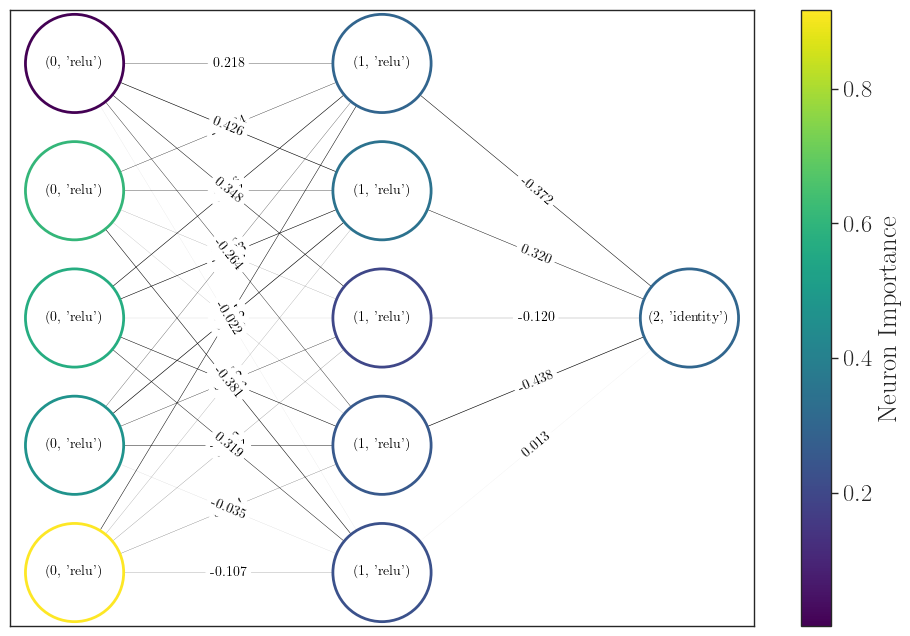

In [ ]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.savefig(f"{fig_folder}/initial_graph.png")
wandb.log({"initial neural network": wandb.Image(plt, caption="initial neural network")})

In [ ]:
@eqx.filter_value_and_grad()
def compute_loss(mlp, x, y):
    pred = jax.vmap(mlp)(x)
    return jnp.mean((pred - y) ** 2)

In [ ]:
@eqx.filter_jit()
def train_step(mlp, x, y, opt_state, opt_update):
    loss, grads = compute_loss(mlp, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    mlp = eqx.apply_updates(mlp, updates)
    return loss, mlp, opt_state

In [ ]:
x = jnp.linspace(0, 2*jnp.pi, n_samples).reshape(-1, 1)
y = jnp.sin(x)

In [ ]:
opt = optax.adabelief(learning_rate=learning_rate)
opt_state = initialize_optimizer_state(mlp, opt)

In [ ]:
initial_adjacency_matrix = mlp.adjacency_matrix()

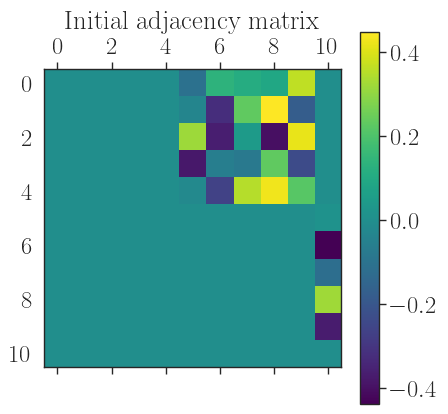

In [ ]:
plt.matshow(initial_adjacency_matrix, cmap=plt.cm.viridis)
plt.colorbar()
plt.title("Initial adjacency matrix")
plt.savefig(f"{fig_folder}/initial_adjacency_matrix.png")
wandb.log({"initial adjacency matrix": wandb.Image(plt, caption="initial adjacency matrix")})

In [ ]:
Loss_history = []
Node_history = []
graph_history = []
Update_history = []

In [ ]:
for epoch in range(num_epochs):
    loss, mlp, opt_state = train_step(mlp, x, y, opt_state, opt.update)

    key, add_key, sub_key = jax.random.split(key,3)
    n_neurons = sum(mlp.get_shape())
    logging.info(f"Epoch {epoch :03d}, Loss: {loss.item()}, Neurons: {n_neurons}")
    wandb.log({"loss": loss.item(), "neurons": n_neurons})
    Loss_history.append(loss)
    Node_history.append(n_neurons)


    # Dynamically add or remove neurons
    if (epoch + 1) % add_node_every == 0:

        #add criterion
        if len(Update_history) == 0 or Update_history[-1][2] > loss:
            # if no previous addition or last addition was rejected, add a neuron
            # if last addition was accepted, add a neuron
            add_key, act_key = jax.random.split(add_key)
            activation = activation_list[jax.random.choice(key, jnp.arange(len(activation_list)))]
            layers = len(mlp.get_shape()) - 1
            layer = jax.random.randint(act_key, (1,), 0, layers)[0]
            mlp.add_neuron(layer_index=layer, activation=activation, key=add_key)
            opt_state = initialize_optimizer_state(mlp, opt)

            Update_history.append((epoch, n_neurons, loss, activation.__name__, layer))
            logging.info(f"Added neuron to hidden layer {layer+1} with activation {activation.__name__}")
            wandb.log({"added neuron": activation.__name__})
            logging.info(f"network shape updated to :{mlp.get_shape()}")
        
        # remove criteria
        elif (Update_history[-1][3] == "removed" and Update_history[-2][2] < loss) or \
            (Update_history[-1][3] != "removed" and Update_history[-1][2] < loss):
            # if last addition was removed check loss against value before that
            # if last addition was accepted, check loss against it
            # if loss doesn't improve, reject it
            layer_key, neuron_key, sub_key = jax.random.split(sub_key,3)
            layer = Update_history[-1][4]
            neuron_idx = len(mlp.layers[layer]) -1

            mlp.remove_neuron(layer_index=layer, neuron_index=neuron_idx)
            opt_state = initialize_optimizer_state(mlp, opt)
            Update_history.append((epoch, n_neurons, loss, "removed", layer))

            logging.info(f"Removed neuron to hidden layer {layer+1} at index {neuron_idx}")
            wandb.log({"removed neuron": neuron_idx})
            logging.info(f"network shape updated to :{mlp.get_shape()}")
        
        
    if loss < threshold:
        # if loss is below threshold, stop training
        logging.info(f"Threshold reached, stopping training at epoch {epoch}")
        wandb.log({"threshold reached": epoch})
        break



Epoch 000, Loss: 0.800280698116291, Neurons: 11
Epoch 000, Loss: 0.800280698116291, Neurons: 11
Epoch 000, Loss: 0.800280698116291, Neurons: 11
Epoch 000, Loss: 0.800280698116291, Neurons: 11
Epoch 000, Loss: 0.800280698116291, Neurons: 11
Epoch 001, Loss: 0.7516523674310822, Neurons: 11
Epoch 001, Loss: 0.7516523674310822, Neurons: 11
Epoch 001, Loss: 0.7516523674310822, Neurons: 11
Epoch 001, Loss: 0.7516523674310822, Neurons: 11
Epoch 001, Loss: 0.7516523674310822, Neurons: 11
Epoch 002, Loss: 0.7059578771150312, Neurons: 11
Epoch 002, Loss: 0.7059578771150312, Neurons: 11
Epoch 002, Loss: 0.7059578771150312, Neurons: 11
Epoch 002, Loss: 0.7059578771150312, Neurons: 11
Epoch 002, Loss: 0.7059578771150312, Neurons: 11
Epoch 003, Loss: 0.6633610382155511, Neurons: 11
Epoch 003, Loss: 0.6633610382155511, Neurons: 11
Epoch 003, Loss: 0.6633610382155511, Neurons: 11
Epoch 003, Loss: 0.6633610382155511, Neurons: 11
Epoch 003, Loss: 0.6633610382155511, Neurons: 11
Epoch 004, Loss: 0.624046

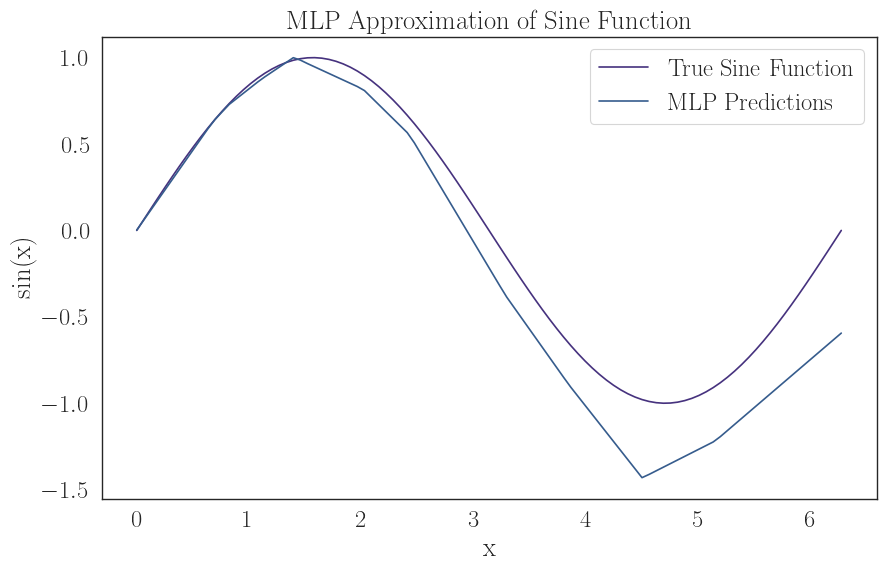

In [ ]:
x_test = jnp.linspace(0, 2* jnp.pi, 100).reshape(-1, 1)
y_test = jnp.sin(x_test)
y_pred = jax.vmap(mlp)(x_test)

plt.figure(figsize=(10, 6))
plt.plot(x_test, y_test, label="True Sine Function")
plt.plot(x_test, y_pred, label="MLP Predictions")
plt.legend()
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.title("MLP Approximation of Sine Function")
plt.savefig(f"{fig_folder}/sine_approximation.png")
wandb.log({"sine approximation": wandb.Image(plt, caption="sine approximation")})


In [ ]:
Update_history

[(49, 11, Array(0.06794344, dtype=float64), 'relu', Array(1, dtype=int64)),
 (99, 12, Array(0.03589897, dtype=float64), 'relu', Array(0, dtype=int64)),
 (149, 13, Array(0.02703456, dtype=float64), 'relu', Array(0, dtype=int64)),
 (199, 14, Array(0.01373839, dtype=float64), 'relu', Array(1, dtype=int64)),
 (249, 15, Array(0.00704744, dtype=float64), 'relu', Array(1, dtype=int64)),
 (299, 16, Array(0.00556191, dtype=float64), 'relu', Array(1, dtype=int64)),
 (349, 17, Array(0.00436994, dtype=float64), 'relu', Array(0, dtype=int64)),
 (399, 18, Array(0.00434248, dtype=float64), 'relu', Array(1, dtype=int64)),
 (449, 19, Array(0.00379201, dtype=float64), 'relu', Array(0, dtype=int64)),
 (499, 20, Array(0.00127736, dtype=float64), 'relu', Array(0, dtype=int64)),
 (549, 21, Array(0.00155901, dtype=float64), 'removed', Array(0, dtype=int64)),
 (599, 20, Array(0.00410298, dtype=float64), 'removed', Array(0, dtype=int64)),
 (649, 19, Array(0.00248753, dtype=float64), 'relu', Array(0, dtype=int6

In [ ]:
final_adjacency_matrix = mlp.adjacency_matrix()

In [ ]:
np.savetxt(f"{out_folder}/final_adjacency_matrix.txt", final_adjacency_matrix)

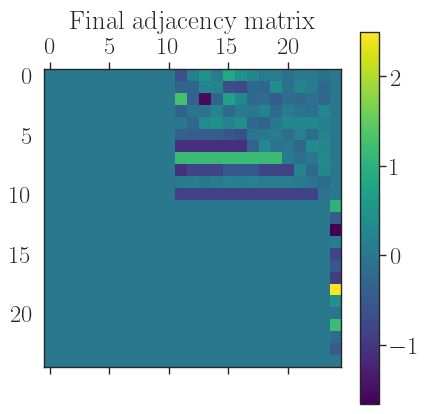

In [ ]:
plt.matshow(final_adjacency_matrix, cmap=plt.cm.viridis)
plt.colorbar()
plt.title("Final adjacency matrix")
plt.savefig(f"{fig_folder}/final_adjacency_matrix.png")
wandb.log({"final adjacency matrix": wandb.Image(plt, caption="final adjacency matrix")})

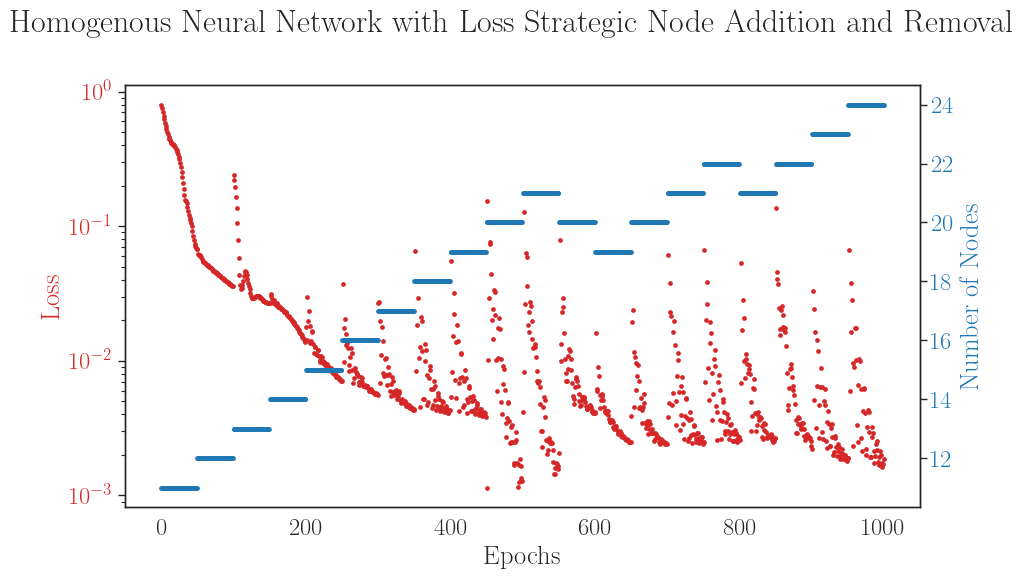

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(0,len(Loss_history)), Loss_history, ".", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0,len(Node_history)), Node_history, ".", color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.suptitle("Homogenous Neural Network with Loss Strategic Node Addition and Removal")
fig.tight_layout()

plt.savefig(f"{fig_folder}/loss_curve.png")
wandb.log({"loss and nodes": wandb.Image(plt, caption="loss and nodes")})

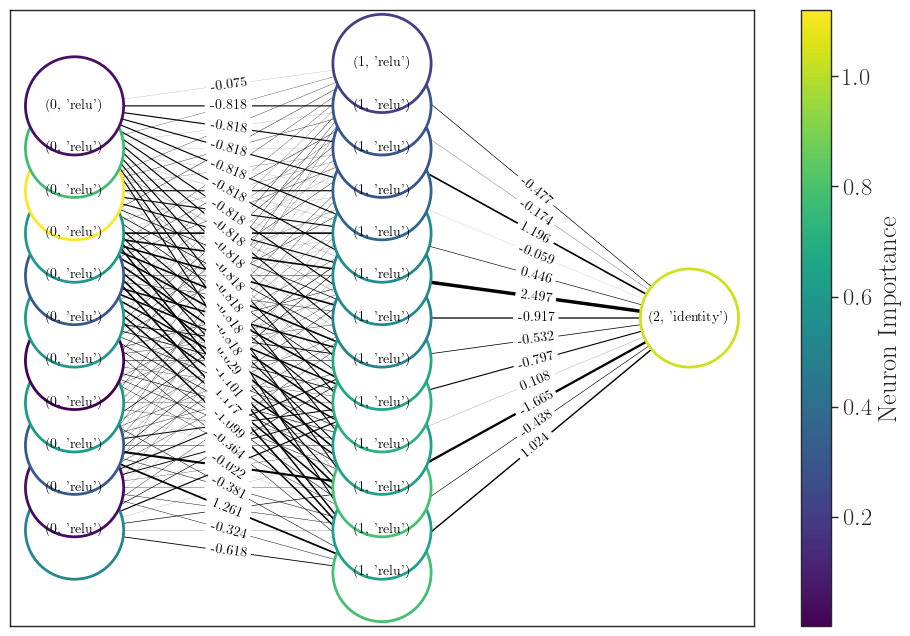

In [ ]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.savefig(f"{fig_folder}/final_graph.png")
wandb.log({"final neural network": wandb.Image(plt, caption="final neural network")})

In [ ]:
wandb.finish()